#The Fluties - In The Money (ITM)

The Fluties pays out the top two spots. Let's investigate if we can predict how the top two spots will be.

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import stats

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE

full_scaled_teams = pd.read_csv("scaled_teams.csv")

In [2]:
def calc_itm_last(group):
    group.loc[group["rankCalculatedFinal"] < 3, 'itm'] = 1
    group.loc[group["rankCalculatedFinal"] >= 3, 'itm'] = 0
    group.loc[group["rankCalculatedFinal"] == 0, 'itm'] = np.nan
    group.loc[(group["rankCalculatedFinal"] == group["rankCalculatedFinal"].max()) & (group["rankCalculatedFinal"] != 0), 'last_place'] = 1
    group.loc[group["last_place"] != 1, 'last_place'] = 0
    return group

itm_teams = full_scaled_teams.groupby("year").apply(calc_itm_last)
curr_teams = itm_teams.loc[itm_teams["year"] == 2021]
hist_teams = itm_teams.loc[itm_teams["year"] != 2021]
to_save = pd.concat([curr_teams, hist_teams])
to_save.drop(to_save.columns[[0,1]], axis=1, inplace=True)
to_save.to_csv("scaled_teams_itm.csv")

In [3]:
logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(hist_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "playoffSeed", "record.overall.wins"]], hist_teams["itm"])

TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
rfe.ranking_

NameError: name 'rfe' is not defined

In [ ]:
sm_over = SMOTE(random_state=10)
sm_X, sm_y = sm_over.fit_resample(hist_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "playoffSeed", "record.overall.wins"]],  hist_teams["itm"])
logit = sm.Logit(sm_y, sm_X).fit()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.361     
Dependent Variable:  itm               AIC:               153.4704  
Date:                2020-12-17 22:38  BIC:               168.9084  
No. Observations:    162               Log-Likelihood:    -71.735   
Df Model:            4                 LL-Null:           -112.29   
Df Residuals:        157               LLR p-value:       1.0138e-16
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
scaled_pointsFor      1.3154   0.3516  3.7409 0.0002  0.6263  2.0046
scaled_pointsAgainst  0.1793   0.2979  0.6019 0.5473 -0.4046  0.7633
scaled_moves          0.1689   0.2520  0.6702 0.5027 -0.3250  0.6627
playoffSeed          -0.3284   0.0767 -4.2832 0.0000 -0.4787 -0.1781
record.overall.wins   0.1323   0.0659  2.0072 0.0447  0.0031  0.2616
====================================================================

"""

In [ ]:
log_pred = logit.predict(curr_teams[["scaled_pointsFor", "scaled_pointsAgainst", "scaled_moves", "playoffSeed", "record.overall.wins"]])

In [4]:
curr_teams["sm_pred"] = log_pred.values
curr_teams[["abbrev", "playoffSeed", "sm_pred"]]

NameError: name 'log_pred' is not defined

In [5]:
oversample = SMOTE(random_state=10)
X, y = oversample.fit_resample(hist_teams[["scaled_pointsFor", "scaled_moves", "playoffSeed"]],  hist_teams["itm"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [7]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


In [8]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[19  5]
 [ 8 23]]


In [9]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.79      0.75        24
         1.0       0.82      0.74      0.78        31

    accuracy                           0.76        55
   macro avg       0.76      0.77      0.76        55
weighted avg       0.77      0.76      0.76        55



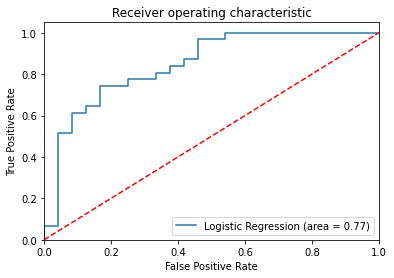

In [10]:

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [11]:
skl_pred = logreg.predict(curr_teams[["scaled_pointsFor", "scaled_moves", "playoffSeed"]])
curr_teams["skl_pred"] = skl_pred
curr_teams[["abbrev", "playoffSeed", "skl_pred"]]

/tmp/ipykernel_2036/3369455017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_teams["skl_pred"] = skl_pred


,abbrev,playoffSeed,skl_pred
0,Caw,5,1.0
1,TOTY,8,0.0
2,Sith,9,0.0
3,TMB,11,0.0
4,Mill,10,0.0
5,BD,3,1.0
6,Rock,6,0.0
7,2021,2,1.0
8,faq,7,0.0
9,JJJ,12,0.0
